SOURCES: 
- Paper and data: https://smoosavi.org/datasets/us_accidents
- Global traffic index: https://www.tomtom.com/en_gb/traffic-index/ranking/
- Imputing missing weather data: https://dl.acm.org/doi/abs/10.1145/3077584.3077592
- About pressure: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.151.3435&rep=rep1&type=pdf
- For the use of hyperopt: Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. To appear in Proc. of the 30th International Conference on Machine Learning (ICML 2013).


### Important information
- In 2019, San Francisco ranked #3 in the USA and #59 in the world out of 416 cities in terms of traffic congestion losing 147 hours stuck on the road. [(TomTom Traffic Index)](https://www.tomtom.com/en_gb/traffic-index/ranking/)
- In 2019, San Francisco ranked #7 in the USA and #30 in the world out of 979 cities in terms of traffic congestion losing 97 hours stuck on the road. [(INRIX 2019 Global Traffic Scorecard)](https://inrix.com/scorecard)
- Intelligent Transportation System (ITS) Technologies: Emerging ITS technology could dramatically reduce the number of collisions on the nation's highways. A recent analysis suggests that a reduction of more than 1 million collisions per year is possible by 2020. This would correspond to a USD 25.6 billion economic savings per year. [National Highway Traffic Safety Administration](https://one.nhtsa.gov/nhtsa/whatis/planning/2020Report/2020report.html)
- ["The Economic Impact of Motor Vehicle Crashes 2000" by NHTSA](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/809446) estimates the yearly economic cost of roadway crashes includes:
    - USD 61 billion in lost workplace productivity
    - USD 20.2 billion in lost household productivity
    - USD 59 billion in property damage
    - USD 32.6 billion in medical costs
    - USD 25.6 billion in travel delay costs.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
from tqdm.autonotebook import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.decomposition import PCA

from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold, StratifiedKFold
import gc
from sklearn.metrics import roc_auc_score, roc_curve
import time

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<div><span style="background-color: ##FF5733; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold">LOAD AND FILTER DATASET</span></div>

In [2]:
df1 = pd.read_csv('US_Accidents_June20.csv')

In [3]:
df1.shape

(3513740, 49)

In [4]:
df1.State.unique()

array(['OH', 'WV', 'CA', 'FL', 'GA', 'SC', 'NE', 'IA', 'IL', 'MO', 'WI',
       'IN', 'MI', 'NJ', 'NY', 'CT', 'MA', 'RI', 'NH', 'PA', 'KY', 'MD',
       'VA', 'DC', 'DE', 'TX', 'WA', 'OR', 'AL', 'TN', 'NC', 'KS', 'LA',
       'OK', 'CO', 'UT', 'AZ', 'MN', 'MS', 'NV', 'ME', 'AR', 'ID', 'VT',
       'NM', 'ND', 'WY', 'SD', 'MT'], dtype=object)

In [5]:
# sf = pd.read_csv('SF_Accidents_June20.csv')
sf = df1[df1.City=='San Francisco'].copy()

In [6]:
sf.Severity.value_counts()

2    6031
3    3662
1     192
4     109
Name: Severity, dtype: int64

In [7]:
sf.head(2)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
735,A-736,MapQuest,201.0,3,2016-06-21 10:51:31,2016-06-21 11:21:31,37.719162,-122.448273,NaN,NaN,0.0,Accident on I-280 Northbound at Geneva Ave.,NaN,John F Foran Fwy,R,San Francisco,San Francisco,CA,94112,US,US/Pacific,KSFO,2016-06-21 10:56:00,71.1,NaN,55.0,30.04,10.0,NE,4.6,NaN,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
765,A-766,MapQuest,201.0,3,2016-06-21 12:46:38,2016-06-21 13:16:38,37.732746,-122.404938,NaN,NaN,0.0,#1 lane blocked due to accident on US-101 Sout...,1612.0,Silver Ave,R,San Francisco,San Francisco,CA,94134-1230,US,US/Pacific,KSFO,2016-06-21 12:56:00,73.0,NaN,44.0,30.02,10.0,WNW,19.6,NaN,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


<div><span style="background-color: ##FF5733; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold">DATA CLEANING AND IMPUTATION</span></div>

In [8]:
def geohash(x):
    return pgh.encode(x[0], x[1], precision=6)

def clean_data(df):
    #drop features
    df = df.drop(['ID', 'TMC', 'Source', 'End_Lat', 'End_Lng', 'Number',
                  'Description', 'City', 'State', 'County', 'Country',
                  'Timezone', 'Airport_Code', 'Zipcode', 'Weather_Timestamp', 
                  'Bump', 'Roundabout', 'Turning_Loop',
                  'Distance(mi)'], axis=1)
    
    # Split dates
    df.Start_Time = pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
    df.End_Time = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S')    
    df['Start_Time_Year'] = df.Start_Time.apply(lambda x : x.year)
    df['Start_Time_Month'] = df.Start_Time.apply(lambda x : x.month)
    df['Start_Time_Day'] = df.Start_Time.apply(lambda x : x.day)
    df['Start_Time_Dayweek'] = df.Start_Time.apply(lambda x : x.day_name())
    df['Start_Time_Hour'] = df.Start_Time.apply(lambda x : x.hour)
    df['Start_Time_Minute'] = df.Start_Time.apply(lambda x : x.minute)

    
    df = df.drop(['Start_Time', 'End_Time'], axis=1)

    
    # Geohash
    df['Geohash'] = df[['Start_Lat', 'Start_Lng']].apply(geohash, axis=1)
    df = df.drop(['Start_Lat', 'Start_Lng'], axis=1)
    
    # Remove accidents not in San Francisco
    notin_sf = ['9q8ynd', '9q8ynf', '9q8yn9', '9q8yp0', '9q8vyz', '9q8vzp']
    df = df[~df['Geohash'].isin(notin_sf)]
    
    # Replace True-False to 1-0
    df[['Amenity',  'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
        'Railway',  'Station', 'Stop', 'Traffic_Calming',
        'Traffic_Signal']] = (df[['Amenity', 'Crossing', 'Give_Way', 
                                                 'Junction', 'No_Exit', 
                                                 'Railway', 
                                                 'Station', 'Stop',
                                                 'Traffic_Calming',
                                                 'Traffic_Signal']].astype(int))

    
    # Clean weather data
    cols = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
            'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
    X = df[cols].to_numpy() 
    imputer = KNNImputer(n_neighbors=2)
    df[cols] = imputer.fit_transform(X)
    df['Wind_Direction'] = df['Wind_Direction'].replace({'West' : 'W', 
                                                         'North':'N',
                                                         'South':'S',
                                                         'East':'E',
                                                         'Variable':'VAR',
                                                         'CALM':'Calm'})
    
    
    #Replace Day-Night to 1-0
    df[['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
        'Astronomical_Twilight']] = (df[['Sunrise_Sunset', 'Civil_Twilight', 
                                         'Nautical_Twilight',
                                         'Astronomical_Twilight']]
                                         .replace({'Night' : 0,
                                                   'Day' : 1}))
    
    # One-hot encode categorical variables 
    df = pd.get_dummies(df, 
                        prefix=['Start_Time_Year', 'Start_Time_Month',
                                'Start_Time_Day', 'Start_Time_Dayweek',
                                'Start_Time_Hour',
                                'Start_Time_Minute',
                                'Side', 'Street',
                                'Wind_Direction', 'Weather_Condition',
                                'Geohash'],
                        columns=['Start_Time_Year', 'Start_Time_Month',
                                'Start_Time_Day', 'Start_Time_Dayweek',
                                'Start_Time_Hour',
                                'Start_Time_Minute',
                                'Side', 'Street',
                                'Wind_Direction', 'Weather_Condition',
                                'Geohash'])

    #transform target column from multiclass to binary 
    df.Severity = df.Severity.replace({1:0, 2:0, 3:1, 4:1})

    return df.reset_index(drop=True)

In [9]:
df = clean_data(sf)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Columns: 753 entries, Severity to Geohash_9q8zpu
dtypes: float64(7), int64(15), uint8(731)
memory usage: 8.6 MB


In [10]:
df.head() 

,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Time_Year_2016,Start_Time_Year_2017,Start_Time_Year_2018,Start_Time_Year_2019,Start_Time_Year_2020,Start_Time_Month_1,Start_Time_Month_2,Start_Time_Month_3,Start_Time_Month_4,Start_Time_Month_5,Start_Time_Month_6,Start_Time_Month_7,Start_Time_Month_8,Start_Time_Month_9,Start_Time_Month_10,Start_Time_Month_11,Start_Time_Month_12,Start_Time_Day_1,Start_Time_Day_2,Start_Time_Day_3,Start_Time_Day_4,Start_Time_Day_5,Start_Time_Day_6,Start_Time_Day_7,Start_Time_Day_8,Start_Time_Day_9,Start_Time_Day_10,Start_Time_Day_11,Start_Time_Day_12,Start_Time_Day_13,Start_Time_Day_14,Start_Time_Day_15,Start_Time_Day_16,Start_Time_Day_17,Start_Time_Day_18,Start_Time_Day_19,Start_Time_Day_20,Start_Time_Day_21,Start_Time_Day_22,Start_Time_Day_23,Start_Time_Day_24,Start_Time_Day_25,Start_Time_Day_26,Start_Time_Day_27,Start_Time_Day_28,Start_Time_Day_29,Start_Time_Day_30,Start_Time_Day_31,Start_Time_Dayweek_Friday,Start_Time_Dayweek_Monday,Start_Time_Dayweek_Saturday,Start_Time_Dayweek_Sunday,Start_Time_Dayweek_Thursday,Start_Time_Dayweek_Tuesday,Start_Time_Dayweek_Wednesday,Start_Time_Hour_0,Start_Time_Hour_1,Start_Time_Hour_2,Start_Time_Hour_3,Start_Time_Hour_4,Start_Time_Hour_5,Start_Time_Hour_6,Start_Time_Hour_7,Start_Time_Hour_8,Start_Time_Hour_9,Start_Time_Hour_10,Start_Time_Hour_11,Start_Time_Hour_12,Start_Time_Hour_13,Start_Time_Hour_14,Start_Time_Hour_15,Start_Time_Hour_16,Start_Time_Hour_17,Start_Time_Hour_18,Start_Time_Hour_19,Start_Time_Hour_20,Start_Time_Hour_21,Start_Time_Hour_22,Start_Time_Hour_23,Start_Time_Minute_0,Start_Time_Minute_1,Start_Time_Minute_2,Start_Time_Minute_3,Start_Time_Minute_4,Start_Time_Minute_5,Start_Time_Minute_6,Start_Time_Minute_7,Start_Time_Minute_8,Start_Time_Minute_9,Start_Time_Minute_10,Start_Time_Minute_11,Start_Time_Minute_12,Start_Time_Minute_13,Start_Time_Minute_14,Start_Time_Minute_15,Start_Time_Minute_16,Start_Time_Minute_17,Start_Time_Minute_18,Start_Time_Minute_19,Start_Time_Minute_20,Start_Time_Minute_21,Start_Time_Minute_22,Start_Time_Minute_23,Start_Time_Minute_24,Start_Time_Minute_25,Start_Time_Minute_26,Start_Time_Minute_27,Start_Time_Minute_28,Start_Time_Minute_29,Start_Time_Minute_30,Start_Time_Minute_31,Start_Time_Minute_32,Start_Time_Minute_33,Start_Time_Minute_34,Start_Time_Minute_35,Start_Time_Minute_36,Start_Time_Minute_37,Start_Time_Minute_38,Start_Time_Minute_39,Start_Time_Minute_40,Start_Time_Minute_41,Start_Time_Minute_42,Start_Time_Minute_43,Start_Time_Minute_44,Start_Time_Minute_45,Start_Time_Minute_46,Start_Time_Minute_47,Start_Time_Minute_48,Start_Time_Minute_49,Start_Time_Minute_50,Start_Time_Minute_51,Start_Time_Minute_52,Start_Time_Minute_53,Start_Time_Minute_54,Start_Time_Minute_55,Start_Time_Minute_56,Start_Time_Minute_57,Start_Time_Minute_58,Start_Time_Minute_59,Side_L,Side_R,Street_ 10th St,Street_ 13th St,Street_ 14th Ave,Street_ 16th St,Street_ 17th St,Street_ 18th St,Street_ 19th Ave,Street_ 1st St,Street_ 22nd St,Street_ 26th Ave,Street_ 2nd St,Street_ 3rd St,Street_ 4th St,Street_ 5th St,Street_ 6th St,Street_ 7th St,Street_ 8th St,Street_ 9th St,Street_ Alameda St,Street_ Alemany Blvd,Street_ Arguello Blvd,Street_ Baker St,Street_ Battery St,Street_ Bay Shore Blvd,Street_ Bay St,Street_ Bayshore Blvd,Street_ Boardman Pl,Street_ Boutwell St,Street_ Brannan St,Street_ Bryant St,Street_ California St,Street_ College Ave,Street_ Connecticut St,Street_ Cortland Ave,Street_ Costa St,Street_ Crescent Ave,Street_ Divisadero St,Street_ Division St,Street_ Duboce Ave,Street_ Dwight St,Street_ El Camino Del Mar,Street_ Elgin Park,Street_ Ellsworth St,Street_ Euclid Ave,Street_ Fell St,Street_ Folsom St,Street_ Forest Rd,Street_ Franklin St,Street_ Fremont St,Street_ Fulton St,Street_ Geary Blvd,Stre

In [11]:
df.shape

(9937, 753)

In [12]:
pcc = df.Severity.value_counts()
pcc

0    6169
1    3768
Name: Severity, dtype: int64

In [13]:
print("PCC BASELINE (%): ", (((pcc/pcc.sum())**2).sum())*125)

PCC BASELINE (%):  66.14883107443251


---

<div><span style="background-color: ##FF5733; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold">CLASSIFICATION MODEL</span></div>

In [14]:
target = df.Severity
features = df.drop('Severity', axis=1)

X_new = features.copy()
X_new['target'] = target.values

In [15]:
X_new.columns

Index(['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity',
       'Crossing', 'Give_Way',
       ...
       'Geohash_9q8zp1', 'Geohash_9q8zp3', 'Geohash_9q8zp6', 'Geohash_9q8zp7',
       'Geohash_9q8zpe', 'Geohash_9q8zpk', 'Geohash_9q8zpq', 'Geohash_9q8zps',
       'Geohash_9q8zpu', 'target'],
      dtype='object', length=753)

In [16]:
def display_importances(feature_importance_df_, model_name):
    
    topn = 10
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:topn].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 5))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f' {model_name} Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(f'{model_name}_importances01.png')
    
def classify(clf, X_new, num_folds, model_name, stratified = False):
    
    # filter for tree-based models
    tree_list = ['GBM', 'Light GBM', 'RF']
    if model_name in tree_list:
        tree=True
    else:
        tree=False
    
    # Divide in training/validation and test data 80-20%         
    df_features = X_new.drop('target', axis=1)
    df_target = X_new.target
    X_train, X_test, y_train, y_test = train_test_split(df_features,
                                                    df_target,
                                                    stratify=df_target,
                                                    test_size=0.2,
                                                    random_state=1)
    train_df= pd.concat([X_train,y_train],axis=1)
    test_df= pd.concat([X_test,y_test],axis=1)
    
#     print("Starting {}. Train-val shape: {}, test shape: {}".format(model_name, train_df.shape, test_df.shape))
#     del df
#     gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
        
    # Create arrays and dataframes to store results
    #test prediction 
#     test_probs = np.zeros(test_df.shape[0])
    test_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    test = []
    train = []
    feats = [f for f in train_df.columns if f not in ['target']]
    
    #K-FOLD, split train to train/valid sets
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
#         print("train set shape: {}, valid set shape: {}".format(train_x.shape, valid_x.shape))

        #training time 
        startTime = time.time()
        clf.fit(train_x, train_y)            
        elapsed_time_train = time.time() - startTime
        train.append(elapsed_time_train)

        #predicted values validation set
        valid_preds = clf.predict(valid_x)
        
         
        if tree:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        else:
            feature_importance_df = 'NaN'  

        print('Fold %2d accuracy : %.6f' % (n_fold + 1, roc_auc_score(valid_y, valid_preds)))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

    #test time 
    startTime = time.time() 
    #predicted values test set
    test_preds += (clf.predict(test_df[feats]))
    elapsed_time_test = time.time() - startTime    
    test.append(elapsed_time_test)

    cr_dict = classification_report(y_test, test_preds,
                                    labels=[0,1],
                                    output_dict=True)
    print(classification_report(y_test, test_preds, labels=[0,1]))
    
    avg_prec = cr_dict['weighted avg']['precision']
    avg_rec = cr_dict['weighted avg']['recall']
    avg_f1_score = cr_dict['weighted avg']['f1-score']
    
#     print("precision: ", avg_prec)
#     print("recall: ", avg_rec)
#     print("f1 score: ", avg_f1_score)
  
    if tree:
        display_importances(feature_importance_df, model_name)
    return feature_importance_df,  pd.DataFrame({'Classification Method' : model_name,
                         'Train Accuracy' : clf.score(train_x, train_y), 
                         'Validation Accuracy' : clf.score(valid_x, valid_y),
                         'Test Accuracy' : clf.score(X_test, y_test), 
                         'Avg Precision' : [avg_prec],
                         'Avg Recall' : [avg_rec],
                         'Avg f1-score' : [avg_f1_score],
                         'Training Time' : np.mean(train),
                         'Test Time' : np.mean(test),                                                 
                        })

# 1. Light GBM

Fold  1 accuracy : 0.779258
Fold  2 accuracy : 0.780495
Fold  3 accuracy : 0.741344
Fold  4 accuracy : 0.784890
Fold  5 accuracy : 0.782572
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1234
           1       0.82      0.69      0.75       754

    accuracy                           0.82      1988
   macro avg       0.82      0.80      0.81      1988
weighted avg       0.82      0.82      0.82      1988



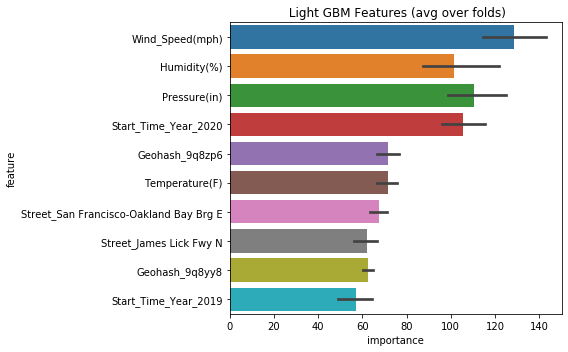

In [17]:
nfolds = 5

lgbm = LGBMClassifier(
            learning_rate=0.04,
#             max_depth=10,
            random_state=42
            )
f, res1 = classify(lgbm, X_new, nfolds, "Light GBM")

# 2. GBM

Fold  1 accuracy : 0.803681
Fold  2 accuracy : 0.797329
Fold  3 accuracy : 0.788510
Fold  4 accuracy : 0.787148
Fold  5 accuracy : 0.803866
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1234
           1       0.82      0.71      0.76       754

    accuracy                           0.83      1988
   macro avg       0.83      0.81      0.81      1988
weighted avg       0.83      0.83      0.83      1988



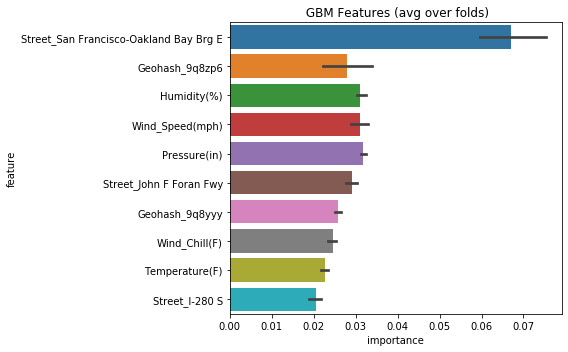

In [18]:
gbm = GradientBoostingClassifier(criterion='mse', max_depth=20, 
                                 learning_rate=0.08, max_features=250,
                                 max_leaf_nodes=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 n_estimators=300, random_state=4)
f, res2 = classify(gbm, X_new, nfolds, "GBM")

# 3. Random Forest

Fold  1 accuracy : 0.801475
Fold  2 accuracy : 0.800765
Fold  3 accuracy : 0.790183
Fold  4 accuracy : 0.793321
Fold  5 accuracy : 0.805120
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1234
           1       0.82      0.70      0.76       754

    accuracy                           0.83      1988
   macro avg       0.83      0.80      0.81      1988
weighted avg       0.83      0.83      0.83      1988



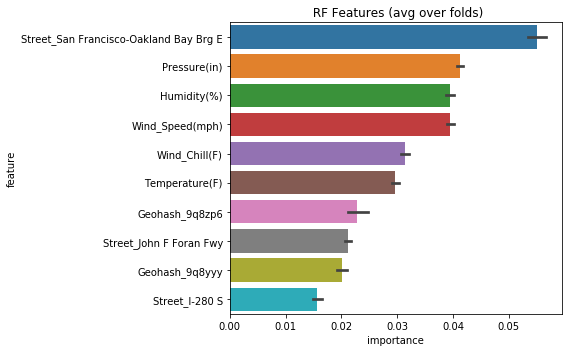

In [19]:
rf = RandomForestClassifier(criterion='entropy', max_depth=40,
                             max_features=250, max_leaf_nodes=None,
                             max_samples=None, min_samples_leaf=1,
                             min_samples_split=2, n_estimators=275,
                             n_jobs=1, random_state=4)
f, res3 = classify(rf, X_new, nfolds, "RF")

# 4. Logistic Regression

In [20]:
lr = LogisticRegression(penalty='l1',solver = 'liblinear',C=0.5)
f, res4 = classify(lr, X_new, nfolds, "LR")

Fold  1 accuracy : 0.782750
Fold  2 accuracy : 0.761801
Fold  3 accuracy : 0.730243
Fold  4 accuracy : 0.773423
Fold  5 accuracy : 0.766385
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1234
           1       0.77      0.65      0.70       754

    accuracy                           0.79      1988
   macro avg       0.78      0.76      0.77      1988
weighted avg       0.79      0.79      0.79      1988



---

<div><span style="background-color: ##FF5733; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold">SUMMARY</span></div>

In [21]:
pd.concat([res1,res2,res3,res4])

,Classification Method,Train Accuracy,Validation Accuracy,Test Accuracy,Avg Precision,Avg Recall,Avg f1-score,Training Time,Test Time
0,Light GBM,0.840723,0.808055,0.823441,0.822825,0.823441,0.820011,0.927183,0.333787
0,GBM,0.999843,0.824418,0.830483,0.829637,0.830483,0.827731,78.130363,0.179916
0,RF,0.997484,0.826306,0.828471,0.827664,0.828471,0.825552,49.876385,0.793511
0,LR,0.800786,0.790434,0.791247,0.789109,0.791247,0.787106,6.094675,0.034664
